# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone. 

Data: https://archive.ics.uci.edu/dataset/222/bank+marketing





### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [169]:
import time
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")

In [170]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [171]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [173]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Age: Ranges from 17 - 98 years of age

Job: Admin is the most common job type

Marital: Mostly married population

Education: Most with a university degree

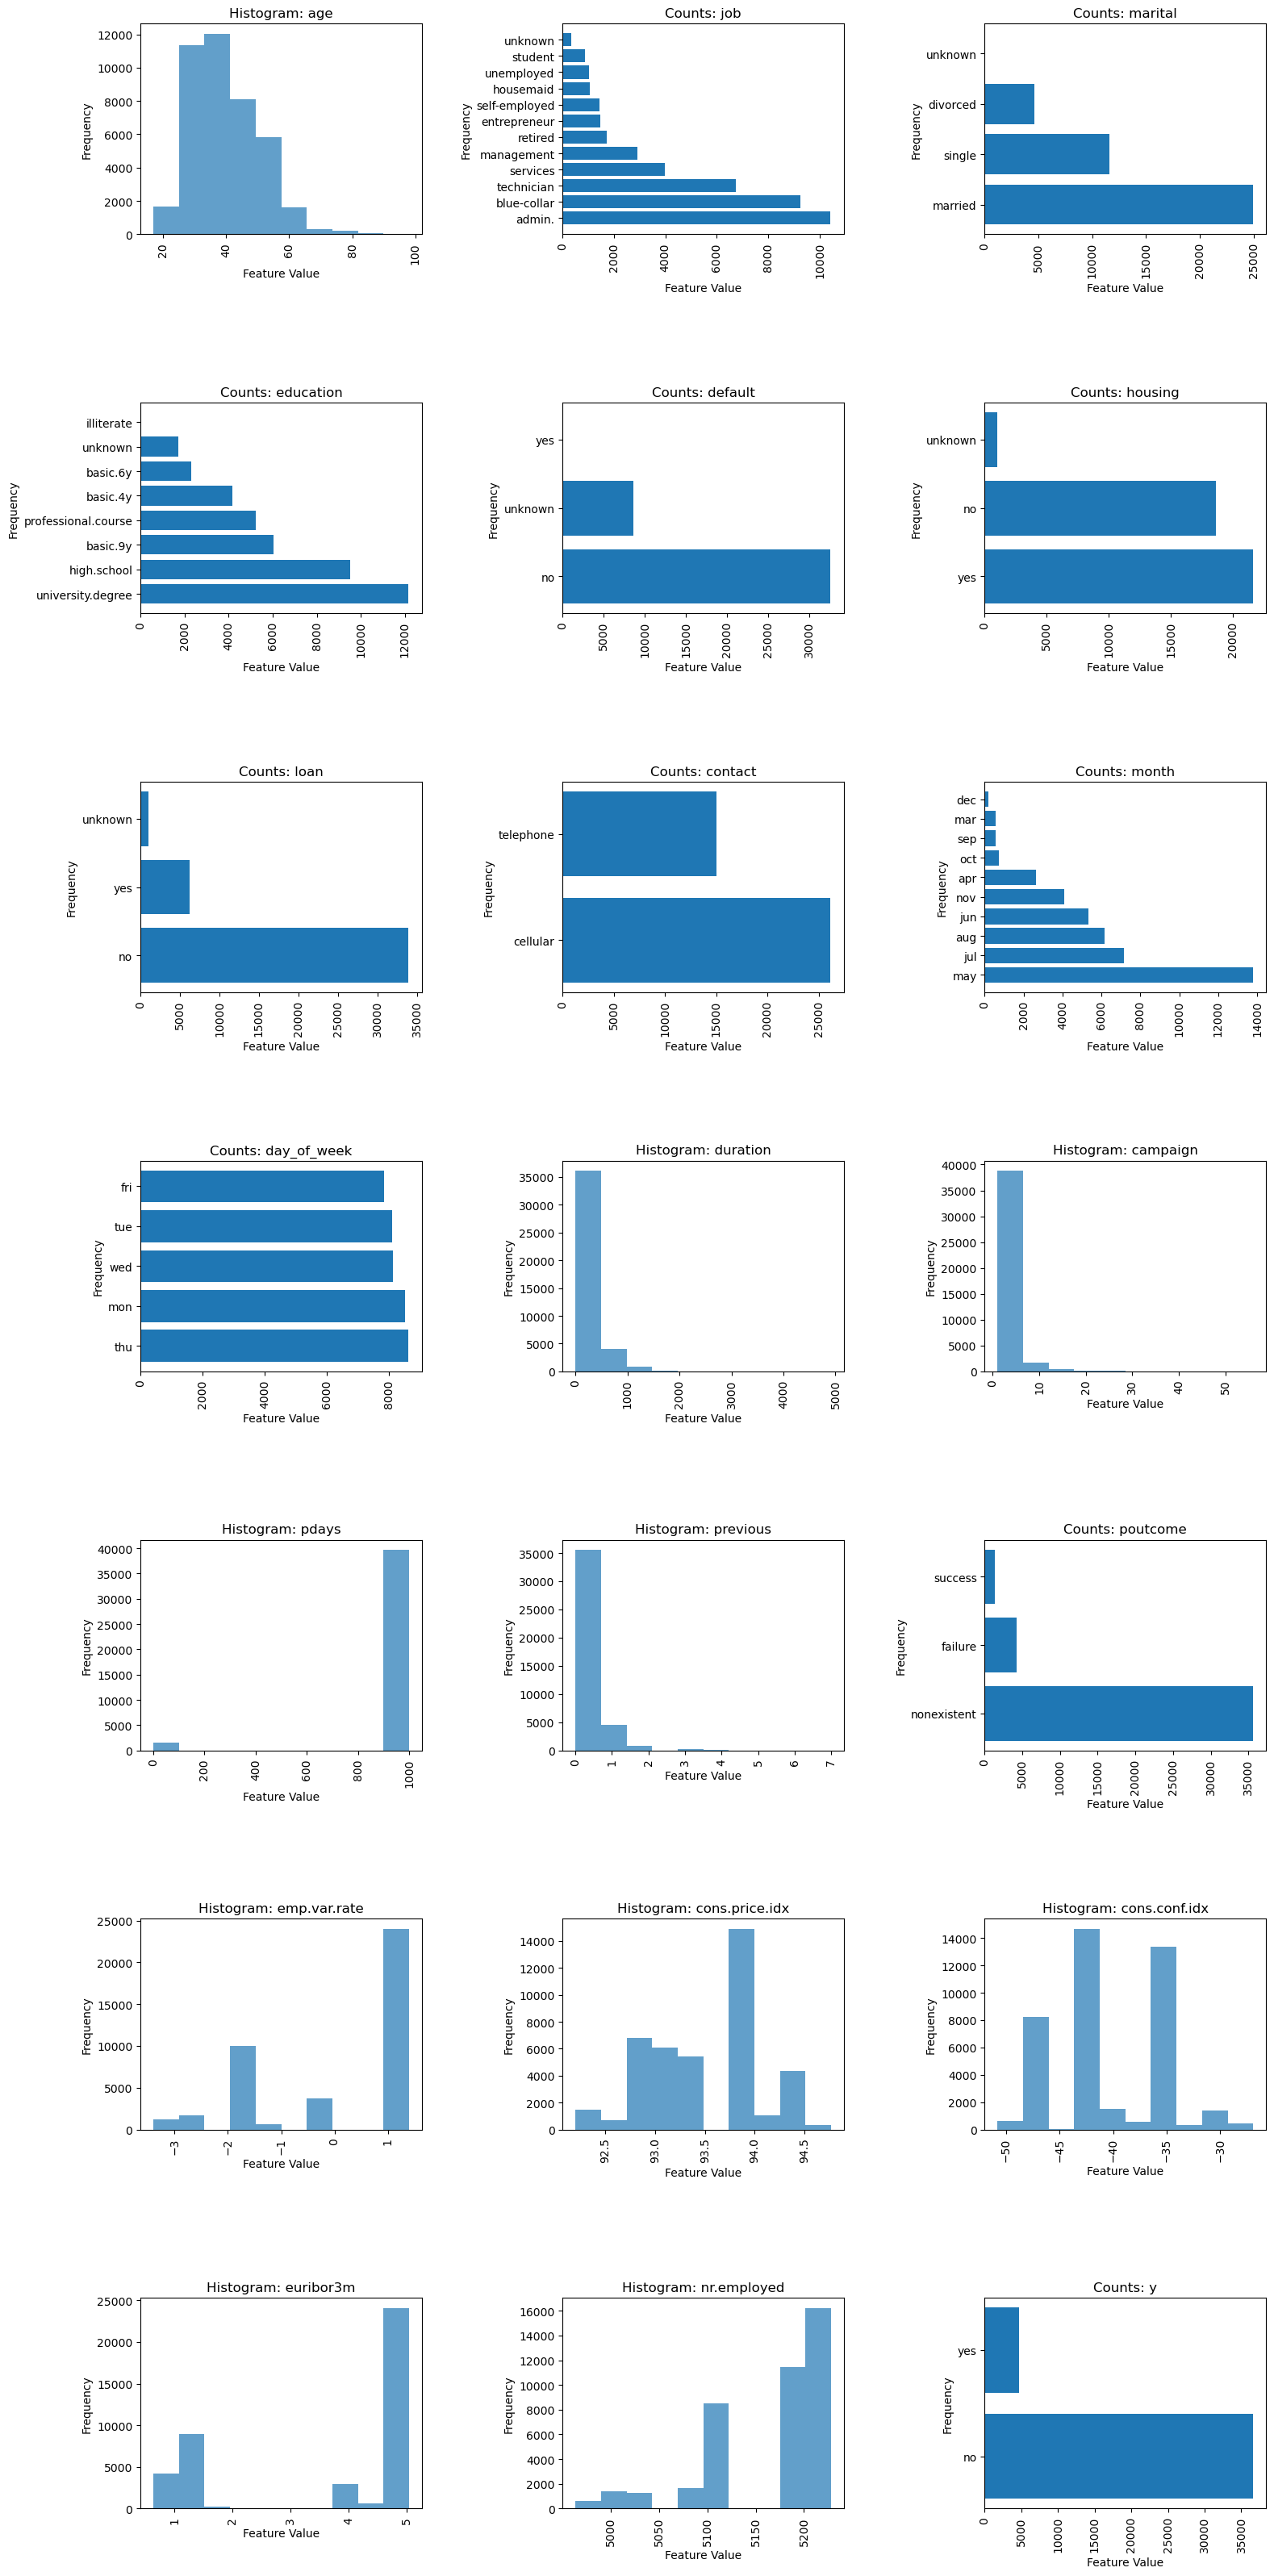

In [174]:

fig, axs = plt.subplots(7, 3, figsize=(18, 40))
catagorical = df.select_dtypes(['object']).columns.tolist()

for ax, column in zip(axs.flat, df.columns):
    if column in catagorical:
        category_counts = df[column].value_counts()
        categories = category_counts.index
        counts = category_counts.values
        ax.barh(categories, counts)
        ax.set_title(f'Counts: {column}')
    else:
        ax.hist(df[[column]], alpha=0.7)
        ax.set_title(f'Histogram: {column}')
    ax.set_xlabel('Feature Value')
    ax.set_ylabel('Frequency')
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.subplots_adjust(hspace=0.8, wspace=0.5)
plt.show()

<Axes: >

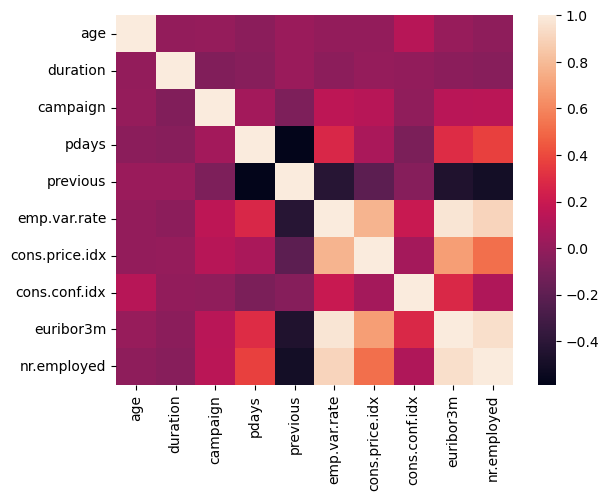

In [175]:
sns.heatmap(df.corr())

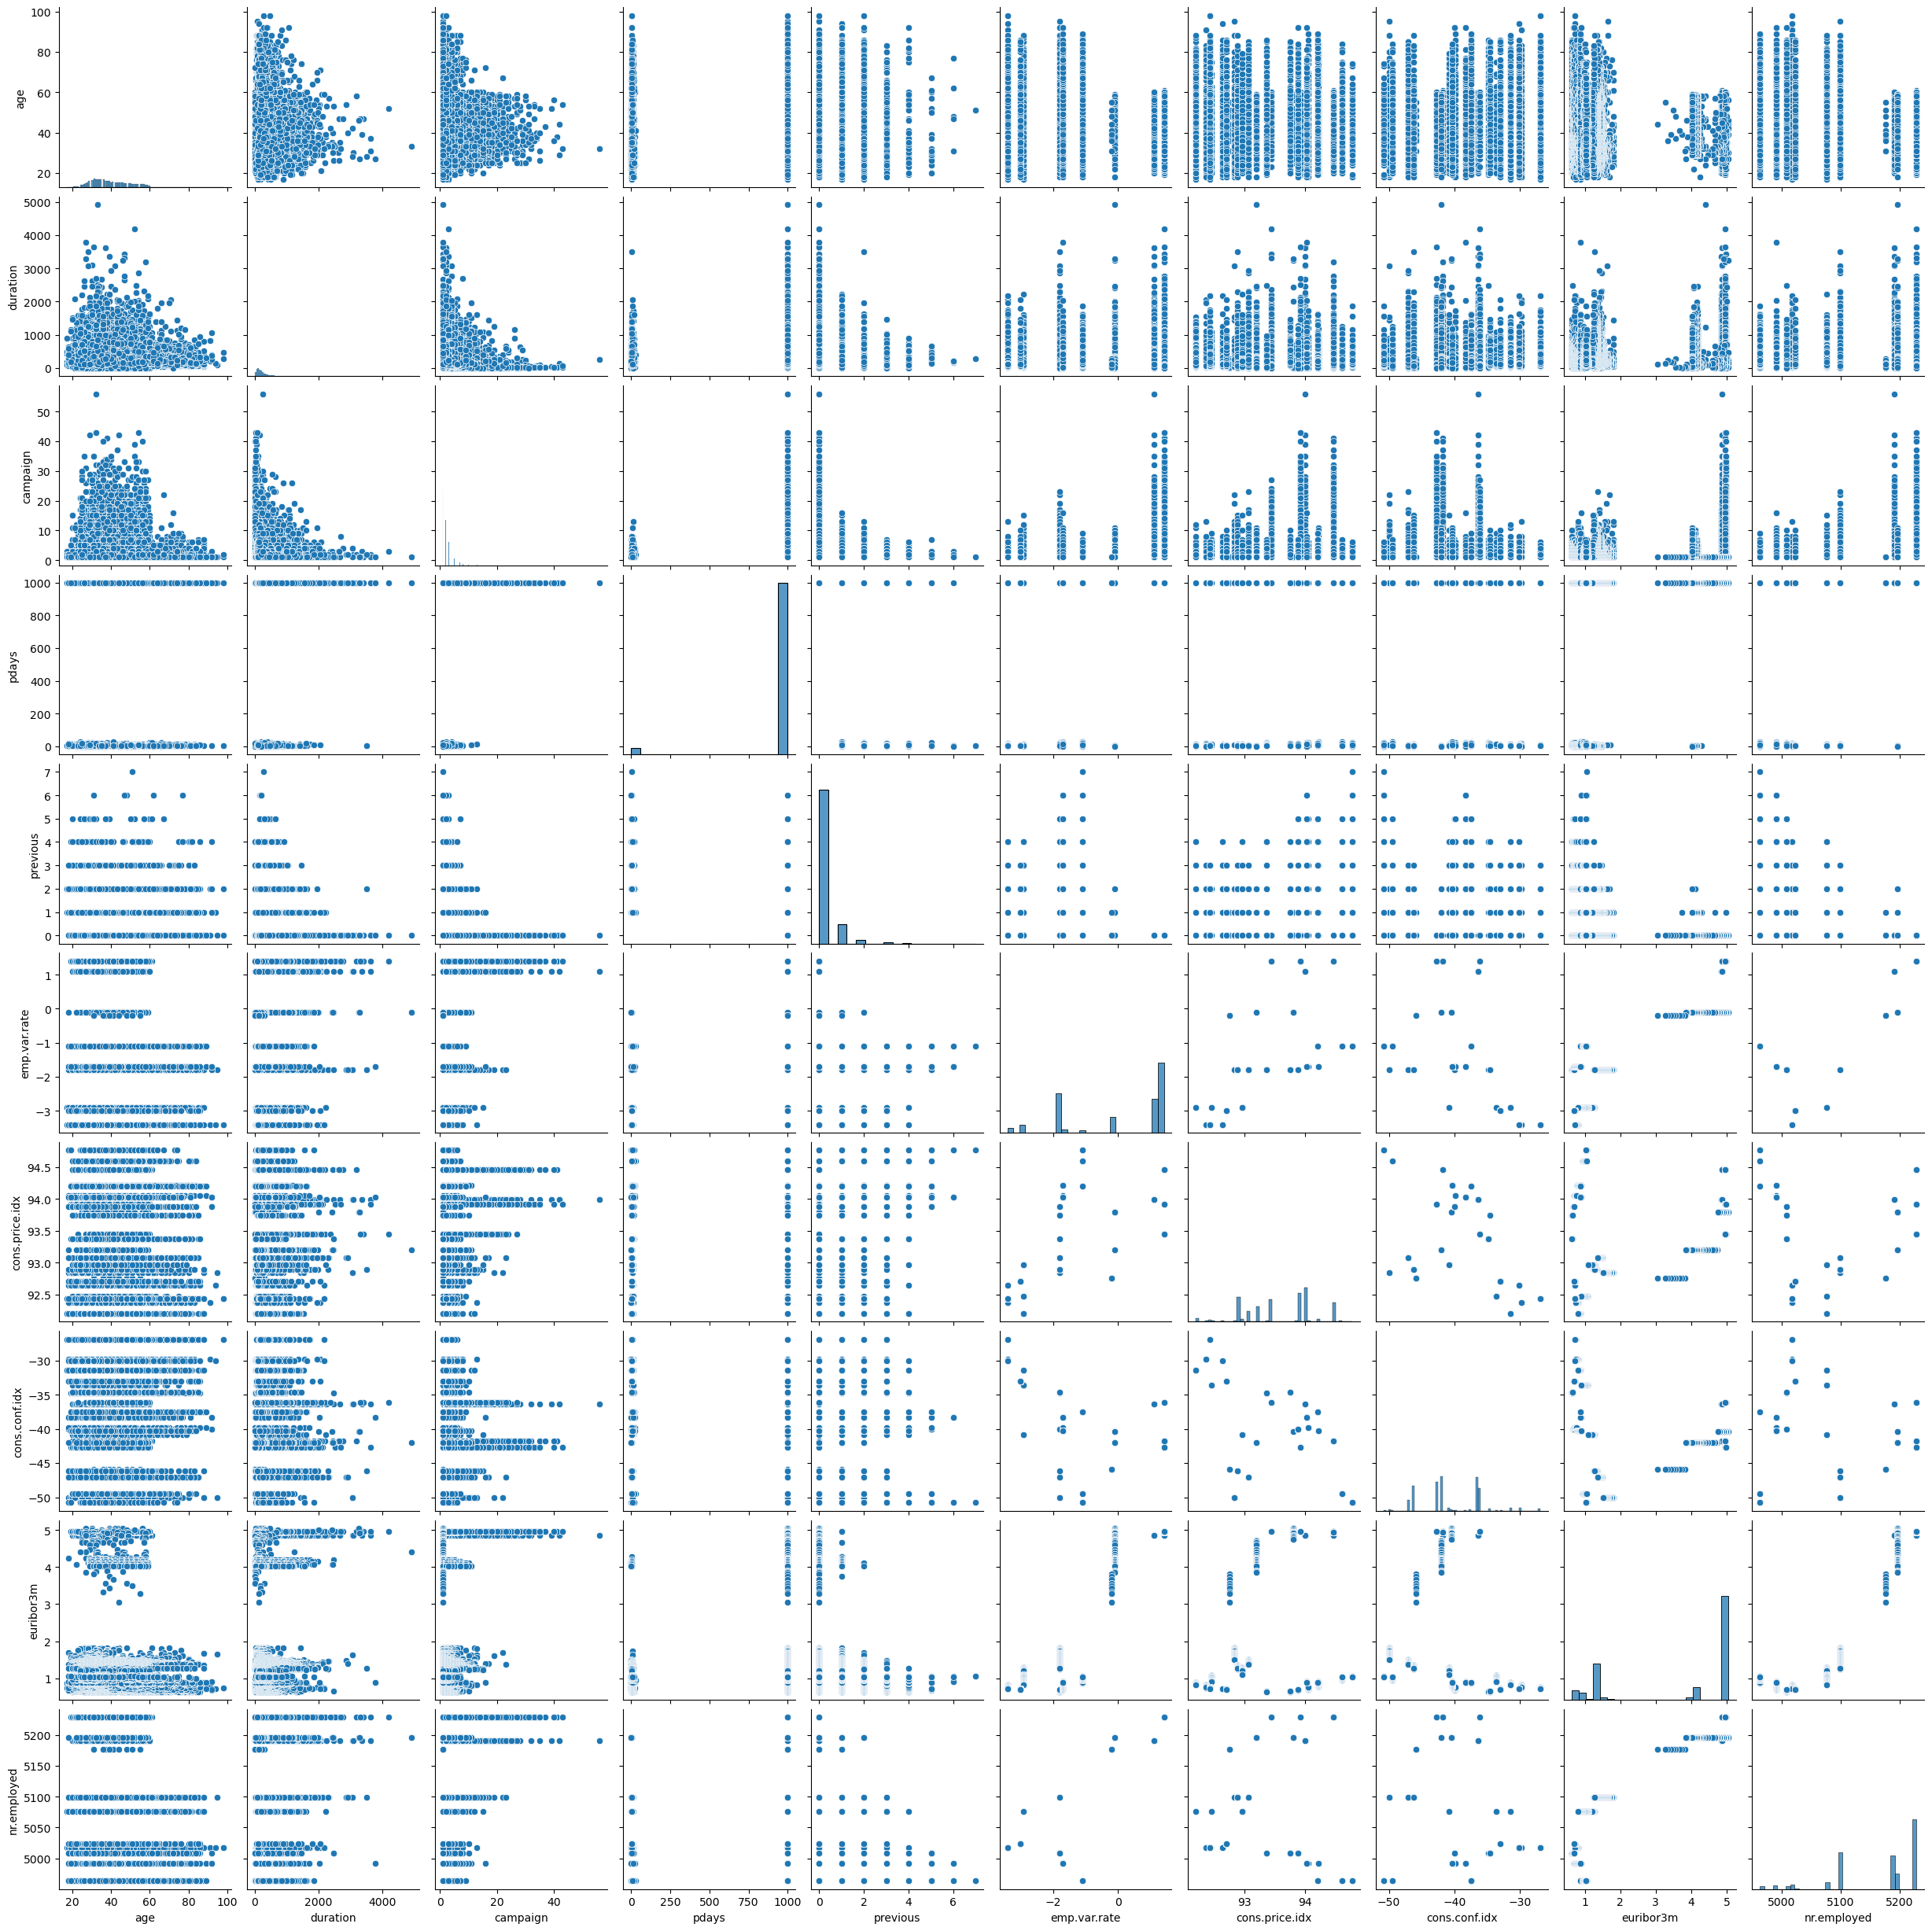

In [193]:
sns.pairplot(df)

In [176]:
# Drop all unknown values
df_clean = df[~df.isin(['unknown']).any(axis=1)]

# Convert to binary
binary_columns = ['default', 'housing', 'loan', 'y']
df_clean[binary_columns] = df_clean[binary_columns].replace({'yes': 1, 'no': 0})

# Data remaining (percentage of original dataframe)
df_clean.shape[0] / df.shape[0]



0.7402155967757599

## Business Objective
The business objective is to optimize the bank's marketing campaigns by accurately predicting which clients are likely to subscribe to term deposits. This will increase conversion, improve customer targeting and reduce operational costs.


### Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [177]:
df_model = df_clean[df_clean.columns[:7].to_list() + ['y']]
df_model

,age,job,marital,education,default,housing,loan,y
0,56,housemaid,married,basic.4y,0,0,0,0
2,37,services,married,high.school,0,1,0,0
3,40,admin.,married,basic.6y,0,0,0,0
4,56,services,married,high.school,0,0,1,0
6,59,admin.,married,professional.course,0,0,0,0
...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,0,1,0,1
41184,46,blue-collar,married,professional.course,0,0,0,0
41185,56,retired,married,university.degree,0,1,0,0
41186,44,technician,married,professional.course,0,0,0,1


### Train/Test Split

With your data prepared, split it into a train and test set.

In [178]:
X = df_model.drop('y', axis=1)
y = df_model['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [179]:
numeric_features = ['age']
categorical_features = ['job', 'marital', 'education']
binary_features = ['default', 'housing', 'loan']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', 'passthrough', binary_features)
    ])

### A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

#### Logistic Regression Base Model

Test Accuracy: 0.8718, Train Accuracy: 0.8741, Fit Time: 0.33623600006103516


Text(0, 0.5, 'Features')

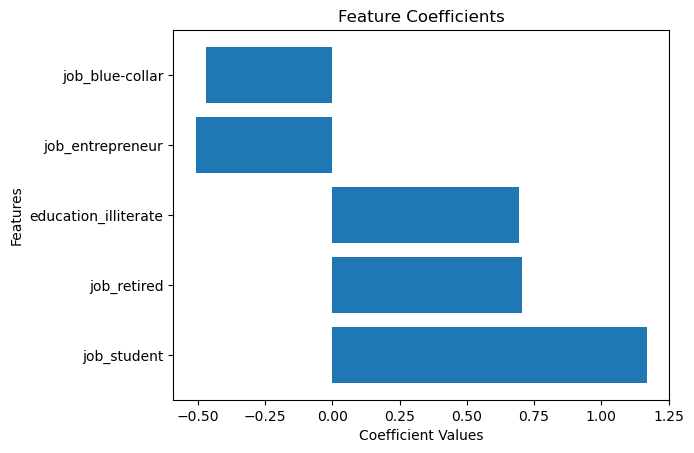

In [180]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression())])

start_time = time.time()
pipeline.fit(X_train, y_train)
Logistic_regression_fit_time = time.time() - start_time

y_test_pred = pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)

Logistic_regression_test_accuracy = accuracy_score(y_test, y_test_pred)
Logistic_regression_train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"Test Accuracy: {Logistic_regression_test_accuracy:.4f}, Train Accuracy: {Logistic_regression_train_accuracy:.4f}, Fit Time: {Logistic_regression_fit_time}")

feature_names = numeric_features + \
                list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)) + \
                binary_features
coeffs = pipeline.named_steps['classifier'].coef_[0]
feature_coefficients = dict(zip(feature_names, coeffs))
five_most_important = sorted(feature_coefficients.items(), key=lambda item: abs(item[1]), reverse=True)[:5]
feature_names, coefficients = zip(*five_most_important)
fig, ax = plt.subplots()
plt.barh(feature_names, coefficients)
ax.set_title("Feature Coefficients")
ax.set_xlabel("Coefficient Values")
ax.set_ylabel("Features")

#### KNN Base Model

In [181]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', KNeighborsClassifier())])
pipeline.fit(X_train, y_train)

start_time = time.time()
pipeline.fit(X_train, y_train)
KNN_fit_time = time.time() - start_time

y_test_pred = pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)

KNN_test_accuracy = accuracy_score(y_test, y_test_pred)
KNN_train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"Test Accuracy: {KNN_test_accuracy:.4f}, Train Accuracy: {KNN_train_accuracy:.4f}, Fit Time: {KNN_fit_time}")



Test Accuracy: 0.8579, Train Accuracy: 0.8761, Fit Time: 0.042961835861206055


#### Decision Tree Base Model

In [182]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', DecisionTreeClassifier())])
pipeline.fit(X_train, y_train)

start_time = time.time()
pipeline.fit(X_train, y_train)
Decision_tree_fit_time = time.time() - start_time

y_test_pred = pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)

Decision_tree_test_accuracy = accuracy_score(y_test, y_test_pred)
Decision_tree_train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"Test Accuracy: {Decision_tree_test_accuracy:.4f}, Train Accuracy: {Decision_tree_train_accuracy:.4f}, Fit Time: {Decision_tree_fit_time}")

print("Feature Importances:")
print(pipeline.named_steps['classifier'].feature_importances_)

Test Accuracy: 0.8530, Train Accuracy: 0.9038, Fit Time: 0.39991188049316406
Feature Importances:
[4.53574106e-01 1.74776485e-02 1.37175805e-02 1.46976421e-02
 1.75041683e-02 2.13401106e-02 1.07067277e-02 1.33994215e-02
 1.46765358e-02 2.47419014e-02 2.53858351e-02 9.53790993e-03
 1.79169854e-02 3.15473954e-02 1.22749124e-02 1.32671304e-02
 1.08377306e-02 1.93383669e-02 2.66845861e-02 7.79260434e-04
 1.86548680e-02 1.42328824e-02 8.99918896e-06 1.21308636e-01
 7.63886588e-02]


#### SVM Base Model

In [183]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SVC())])
pipeline.fit(X_train, y_train)

start_time = time.time()
pipeline.fit(X_train, y_train)
SVC_fit_time = time.time() - start_time

y_test_pred = pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)

SVC_test_accuracy = accuracy_score(y_test, y_test_pred)
SVC_train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"Test Accuracy: {SVC_test_accuracy:.4f}, Train Accuracy: {SVC_train_accuracy:.4f}, Fit Time: {SVC_fit_time}")

Test Accuracy: 0.8718, Train Accuracy: 0.8741, Fit Time: 16.014482021331787


### Base Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:




In [184]:
base_model_performance = pd.DataFrame({
    "model": ["Logistic Regression", "KNN", "Decision Tree", "SVM"],
    "fit time": [Logistic_regression_fit_time, KNN_fit_time, Decision_tree_fit_time, SVC_fit_time],
    "train accuracy": [Logistic_regression_train_accuracy, KNN_train_accuracy, Decision_tree_train_accuracy, SVC_train_accuracy],
    "test accuracy": [Logistic_regression_test_accuracy, KNN_test_accuracy, Decision_tree_test_accuracy, SVC_test_accuracy]
})
base_model_performance

,model,fit time,train accuracy,test accuracy
0,Logistic Regression,0.336236,0.874139,0.871761
1,KNN,0.042962,0.876060,0.857877
2,Decision Tree,0.399912,0.903753,0.852957
3,SVM,16.014482,0.874139,0.871761


### Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

## Feature Engineering

In [185]:
X = df_clean.drop('y', axis=1)
y = df_clean['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

numeric_features = X.select_dtypes(np.number).columns.tolist()
categorical_features = X.select_dtypes(['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ], remainder='passthrough')

In [186]:
data = preprocessor.fit_transform(X_train)
data.shape

(21341, 54)

With 54 features, lets add PCA to reduce dimensionality

In [187]:
pca = PCA(0.95)

## Hyperparameter Tuning

### Logistic Regression

Best parameters for Logistic Regression: {'classifier__C': 0.1, 'classifier__solver': 'newton-cg'}
Best score for Logistic Regression: 0.8997


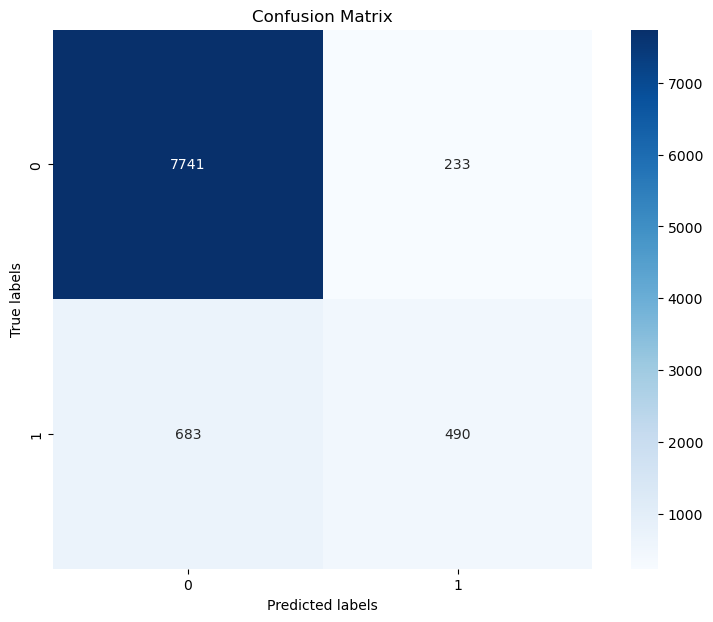

Train Accuracy: 0.8995946831706905
Test Accuracy: 0.8996767414785831
Fit time for the best model: 0.22728276252746582 seconds


In [188]:
parameters = {'classifier__C': [0.1, 1, 10, 100], "classifier__solver": ['liblinear', 'newton-cg']}

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ("pca", pca),
                           ('classifier', LogisticRegression())])

gs = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy', return_train_score=True)

gs.fit(X_train, y_train)

print(f"Best parameters for Logistic Regression: {gs.best_params_}")
print(f"Best score for Logistic Regression: {gs.best_score_:.4f}")

y_pred = gs.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

best_index = gs.best_index_
tuned_logistic_regression_train_accuracy = gs.cv_results_['mean_train_score'][best_index]
print("Train Accuracy:", tuned_logistic_regression_train_accuracy)

tuned_logistic_regression_test_accuracy = gs.best_score_
print("Test Accuracy:", tuned_logistic_regression_test_accuracy)

tuned_logistic_regression_fit_time = gs.cv_results_['mean_fit_time'][best_index]
print(f"Fit time for the best model: {tuned_logistic_regression_fit_time} seconds")


### KNN

Best parameters for KNN: {'classifier__n_neighbors': 10}
Best score for KNN: 0.8919


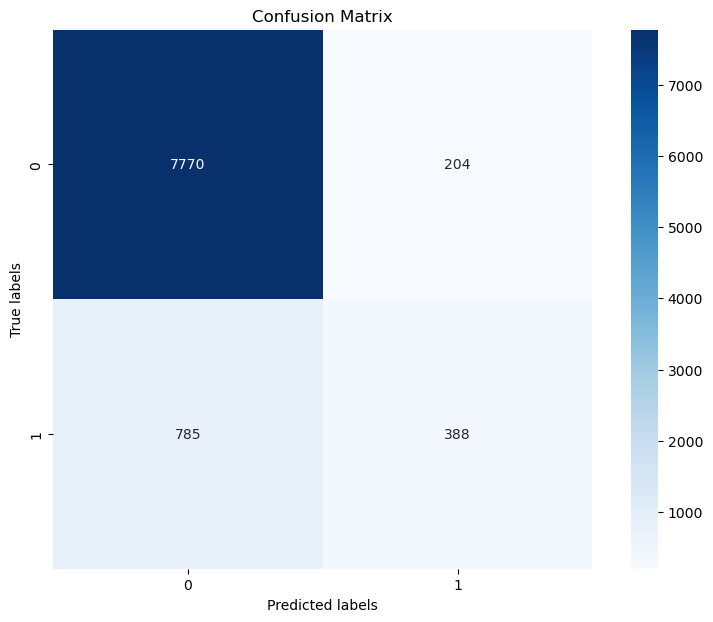

Train Accuracy: 0.9060962728217457
Test Accuracy: 0.8919451669069508
Fit time for the best model: 0.29236230850219724 seconds


In [189]:
parameters = {'classifier__n_neighbors': [3, 5, 7, 10]}

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ("pca", pca),
                           ('classifier', KNeighborsClassifier())])

gs = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy', return_train_score=True)

gs.fit(X_train, y_train)

print(f"Best parameters for KNN: {gs.best_params_}")
print(f"Best score for KNN: {gs.best_score_:.4f}")

y_pred = gs.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

best_index = gs.best_index_
tuned_knn_train_accuracy = gs.cv_results_['mean_train_score'][best_index]
print("Train Accuracy:", tuned_knn_train_accuracy)

tuned_knn_test_accuracy = gs.best_score_
print("Test Accuracy:", tuned_knn_test_accuracy)

tuned_knn_fit_time = gs.cv_results_['mean_fit_time'][best_index]
print(f"Fit time for the best model: {tuned_knn_fit_time} seconds")

### Decision Tree

Best parameters for Decision Tree: {'classifier__max_depth': 5}
Best score for Decision Tree: 0.8906


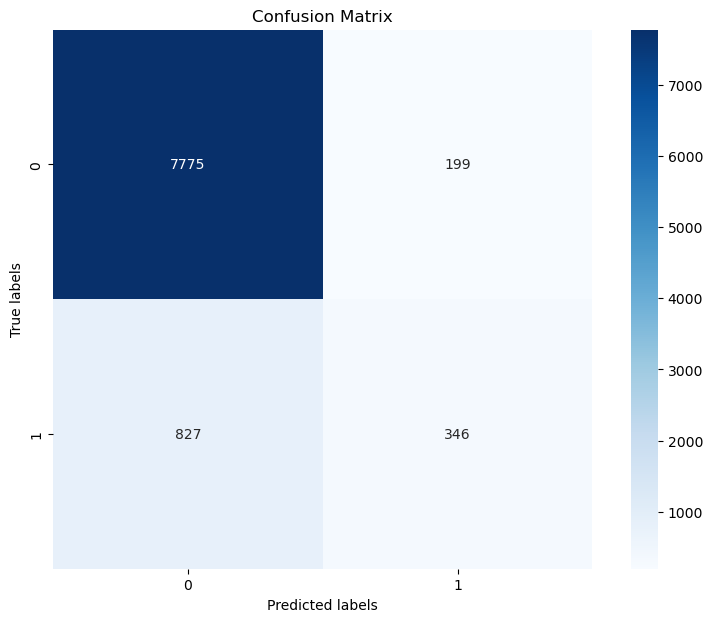

Train Accuracy: 0.9002858185296272
Test Accuracy: 0.8905863263478583
Fit time for the best model: 0.6515885829925537 seconds


In [190]:
parameters = {'classifier__max_depth': [3, 4, 5, 6, 7, 8, 9, 10]}

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('pca', pca),
                           ('classifier', DecisionTreeClassifier())])

gs = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy', return_train_score=True)

gs.fit(X_train, y_train)

print(f"Best parameters for Decision Tree: {gs.best_params_}")
print(f"Best score for Decision Tree: {gs.best_score_:.4f}")

y_pred = gs.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

best_index = gs.best_index_
tuned_decision_tree_train_accuracy = gs.cv_results_['mean_train_score'][best_index]
print("Train Accuracy:", tuned_decision_tree_train_accuracy)

tuned_decision_tree_test_accuracy = gs.best_score_
print("Test Accuracy:", tuned_decision_tree_test_accuracy)

tuned_decision_tree_fit_time = gs.cv_results_['mean_fit_time'][best_index]
print(f"Fit time for the best model: {tuned_decision_tree_fit_time} seconds")

### SVM

Best parameters for SVM: {'classifier__C': 1, 'classifier__kernel': 'rbf'}
Best score for SVM: 0.8991


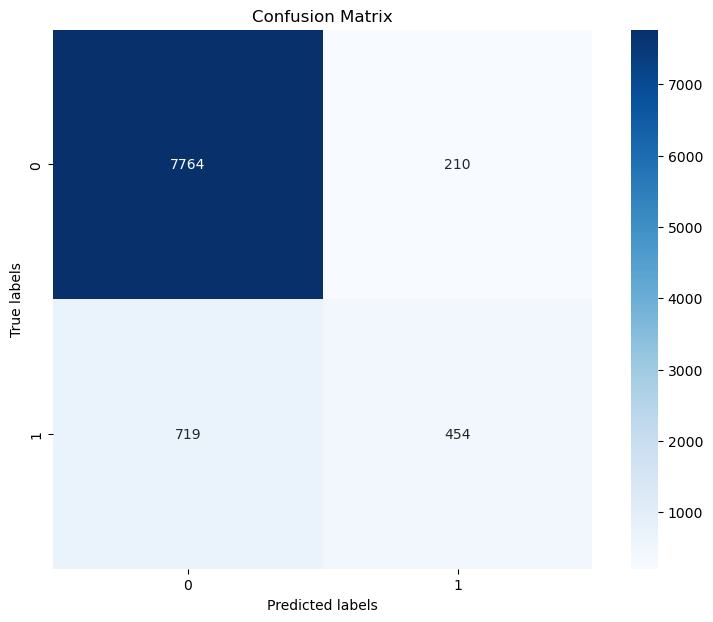

Train Accuracy: 0.9130546843860458
Test Accuracy: 0.8990676227101378
Fit time for the best model: 5.458960628509521 seconds


In [191]:
parameters = {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']}

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('pca', pca),
                           ('classifier', SVC())])

gs = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy', return_train_score=True)

gs.fit(X_train, y_train)

print(f"Best parameters for SVM: {gs.best_params_}")
print(f"Best score for SVM: {gs.best_score_:.4f}")

y_pred = gs.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

best_index = gs.best_index_
tuned_svm_train_accuracy = gs.cv_results_['mean_train_score'][best_index]
print("Train Accuracy:", tuned_svm_train_accuracy)

tuned_svm_test_accuracy = gs.best_score_
print("Test Accuracy:", tuned_svm_test_accuracy)

tuned_svm_fit_time = gs.cv_results_['mean_fit_time'][best_index]
print(f"Fit time for the best model: {tuned_svm_fit_time} seconds")


In [192]:
tuned_model_performance = pd.DataFrame({
    "model": ["Logistic Regression", "KNN", "Decision Tree", "SVM"],
    "fit time": [tuned_logistic_regression_fit_time, tuned_knn_fit_time, tuned_decision_tree_fit_time, tuned_svm_fit_time], 
    "train accuracy": [tuned_logistic_regression_train_accuracy, tuned_knn_train_accuracy, tuned_decision_tree_train_accuracy, tuned_svm_train_accuracy],
    "test accuracy": [tuned_logistic_regression_test_accuracy, tuned_knn_test_accuracy, tuned_decision_tree_test_accuracy, tuned_svm_test_accuracy]
})

tuned_model_performance

,model,fit time,train accuracy,test accuracy
0,Logistic Regression,0.227283,0.899595,0.899677
1,KNN,0.292362,0.906096,0.891945
2,Decision Tree,0.651589,0.900286,0.890586
3,SVM,5.458961,0.913055,0.899068


In [147]:
model_differences = (tuned_model_performance[["fit time", "train accuracy", "test accuracy"]] - base_model_performance[["fit time", "train accuracy", "test accuracy"]])*100
model_differences["model"] = tuned_model_performance["model"]
model_differences

,fit time,train accuracy,test accuracy,model
0,-2.267742,2.545570,2.791551,Logistic Regression
1,5.155902,3.003611,3.406827,KNN
2,8.303890,-0.345581,3.801951,Decision Tree
3,-940.855203,3.891570,2.730639,SVM
